In [4]:
import pandas as pd
from nltk import pos_tag
import nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from string import punctuation
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics

In [5]:
data = pd.read_csv(r"D:\Project\Sentiment Analysis for Marketing\Data\Processed Data\small_corpus.csv")

#shape of the data before dropping the missing values
data.shape

(4500, 12)

In [6]:
data.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,1.0,False,"11 7, 2015",A3I155IWI3QFXI,B00VU4J13W,Metallicafan,Terrible game!! The guns sound ridiculous and ...,:(,1446854400,NaN,{'Format:': ' Video Game'},NaN
1,1.0,False,"08 10, 2008",A3E975KR2HRERX,B000GH3PYK,T. Coleman,fun?! ZERO is what I should be allowed to give...,Challengingly bland...,1218326400,NaN,{'Platform:': ' Sony PSP'},NaN
2,1.0,False,"04 18, 2013",AZITT56TNI5WD,B000SSQPU8,Kewlrane,If you like standard controls you will hate th...,I hate stylus games,1366243200,NaN,{'Format:': ' Video Game'},NaN
3,1.0,True,"04 2, 2015",A2QFWLLKIMU81M,B000OYITQO,Linda Ann Dullinger,it didn't work when I got it.,One Star,1427932800,NaN,NaN,NaN
4,1.0,True,"10 4, 2009",A2KUQ8L9Q3UW5O,B0017HIH6O,Kengineer,I found it hard to get the controls to do what...,Sluggish controls,1254614400,2,NaN,NaN


In [7]:
data.dropna(subset = ['reviewText'],inplace=True)   #dropping the rows with missing values in the column named reviewText

In [8]:
data.shape   #shape of the dataset after dropping the missing values

(4499, 12)

In [9]:
def penn_to_wn(tag):
    """
    Convert Penn Treebank part-of-speech (POS) tags to WordNet POS tags.
    """
    # Check if the tag is an adjective
    if tag.startswith('J'):
        return wn.ADJ  # Return WordNet adjective tag
    # Check if the tag is a noun
    elif tag.startswith('N'):
        return wn.NOUN  # Return WordNet noun tag
    # Check if the tag is an adverb
    elif tag.startswith('R'):
        return wn.ADV  # Return WordNet adverb tag
    # Check if the tag is a verb
    elif tag.startswith('V'):
        return wn.VERB  # Return WordNet verb tag
    
    # If the tag does not match any known type, return None
    return None

In [10]:
def get_sentiment_score(text):
    """
    Calculate the sentiment score of a given text using SentiWordNet.
    """
    # Initialize the total score for the text
    total_score = 0

    # Split the text into sentences
    sentences = sent_tokenize(text)

    # Loop through each sentence to calculate its sentiment score
    for sentence in sentences:
        sentence_score = 0  # Initialize the score for this sentence
        
        # Clean the sentence and make it lowercase
        cleaned_sentence = sentence.replace("<br />", " ")  # Replace HTML line breaks with space
        cleaned_sentence = cleaned_sentence.translate(str.maketrans('', '', punctuation))  # Remove punctuation
        cleaned_sentence = cleaned_sentence.lower()

        # Tokenize the sentence into words
        words = TreebankWordTokenizer().tokenize(cleaned_sentence)

        # Get the part-of-speech (POS) tags for each word
        pos_tags = pos_tag(words)

        # Loop through each word and its POS tag
        for word, tag in pos_tags:
            # Convert Penn Treebank POS tag to WordNet format
            wn_tag = penn_to_wn(tag)
            if not wn_tag:  # Skip if the tag can't be converted
                continue

            # Lemmatize the word (reduce it to its base form)
            lemma = WordNetLemmatizer().lemmatize(word, pos=wn_tag)
            if not lemma:  # Skip if no lemma is found
                continue

            # Get the WordNet synsets (sets of synonyms) for the lemma
            synsets = wn.synsets(lemma, pos=wn_tag)
            if not synsets:  # Skip if no synsets are found
                continue

            # Use the first synset (most common meaning)
            synset = synsets[0]

            # Get the sentiment scores from SentiWordNet
            swn_synset = swn.senti_synset(synset.name())
            sentence_score += swn_synset.pos_score() - swn_synset.neg_score()

        # Add the sentence score to the total, dividing by the number of words to normalize
        if len(words) > 0:
            total_score += (sentence_score / len(words))

    # Return the average sentiment score for all sentences (scaled by 100 for clarity)
    if len(sentences) > 0:
        return (total_score / len(sentences)) * 100
    else:
        return 0


In [11]:
data['swn_score'] = data['reviewText'].apply(lambda text : get_sentiment_score(text))

In [12]:
data[['reviewText','swn_score']].head(2)

,reviewText,swn_score
0,Terrible game!! The guns sound ridiculous and ...,-13.446970
1,fun?! ZERO is what I should be allowed to give...,5.917283


In [13]:
data.columns

Index(['overall', 'verified', 'reviewTime', 'reviewerID', 'asin',
       'reviewerName', 'reviewText', 'summary', 'unixReviewTime', 'vote',
       'style', 'image', 'swn_score'],
      dtype='object')

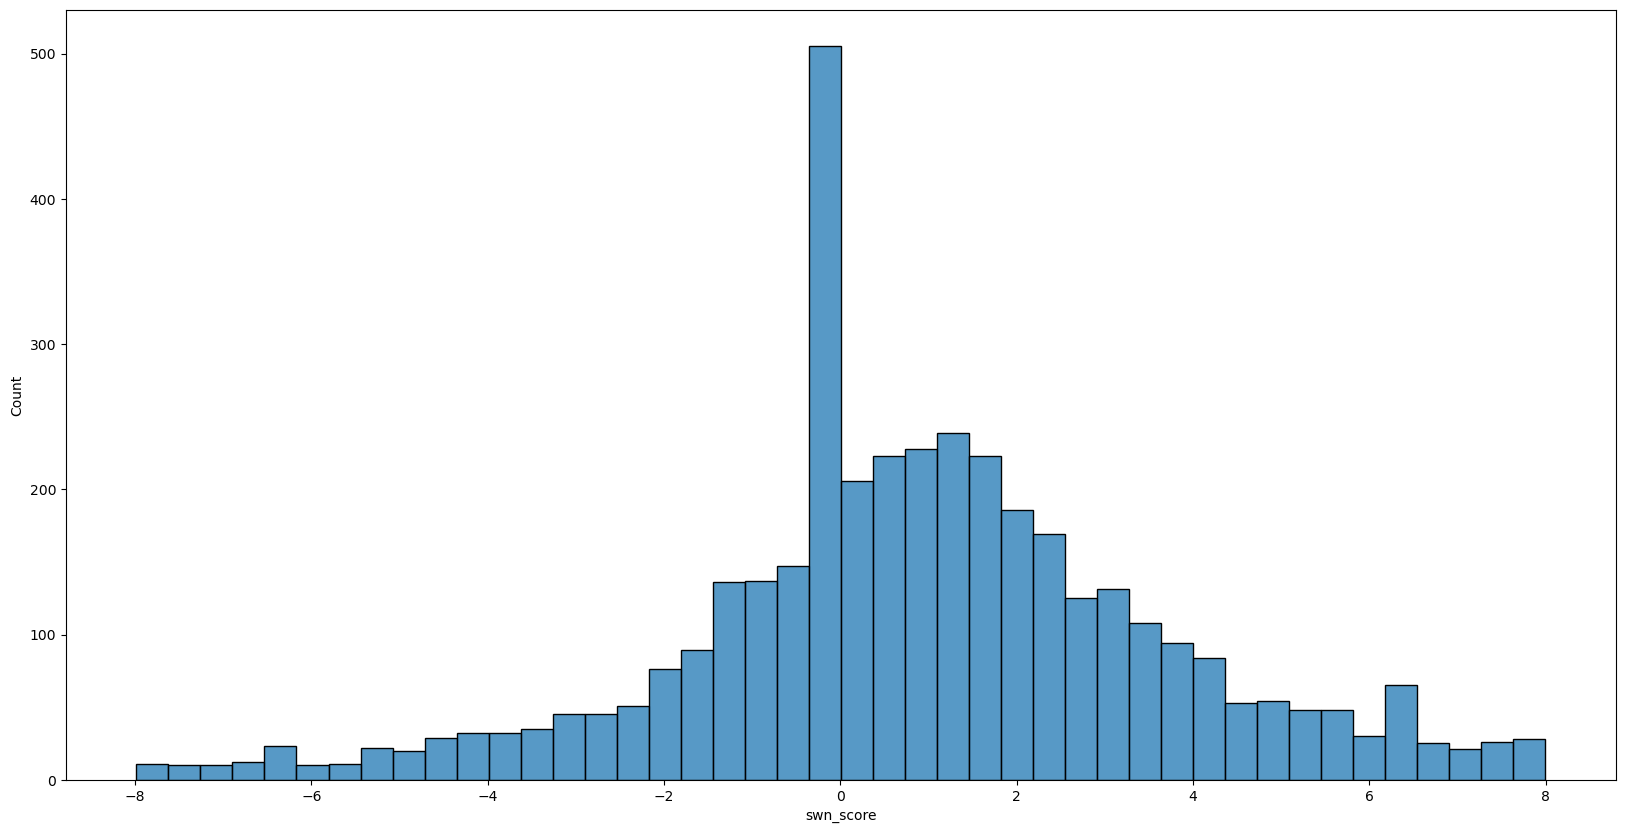

In [14]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.histplot(x='swn_score', data=data.query("swn_score < 8 and swn_score > -8"), ax=ax)
plt.show()

In [15]:
data['swn_sentiment'] = data['swn_score'].apply(lambda i:"positive" if i>1 else "negative" if i<0.5 else 'neutral')

In [16]:
data[["reviewText","swn_score","swn_sentiment"]].head(10)

,reviewText,swn_score,swn_sentiment
0,Terrible game!! The guns sound ridiculous and ...,-13.446970,negative
1,fun?! ZERO is what I should be allowed to give...,5.917283,positive
2,If you like standard controls you will hate th...,-2.083333,negative
3,it didn't work when I got it.,1.785714,positive
4,I found it hard to get the controls to do what...,-1.314484,negative
5,no clear mission,16.666667,positive
6,"Sega used to be a good company, but this is li...",-3.425802,negative
7,This game is not worth the time it takes you t...,-2.380952,negative
8,it came in a sandwich bag dude and i think who...,0.581395,neutral
9,Its a shame to much opposite to the regular MO...,1.470588,positive


In [17]:
data.isna().sum()

overall              0
verified             0
reviewTime           0
reviewerID           0
asin                 0
reviewerName         0
reviewText           0
summary              3
unixReviewTime       0
vote              3130
style             1835
image             4462
swn_score            0
swn_sentiment        0
dtype: int64

In [18]:
data["swn_sentiment"].value_counts()

swn_sentiment
positive    2264
negative    1927
neutral      308
Name: count, dtype: int64

In [19]:
data["overall"].unique()

array([1., 2., 3., 4., 5.])

<Axes: xlabel='overall', ylabel='count'>

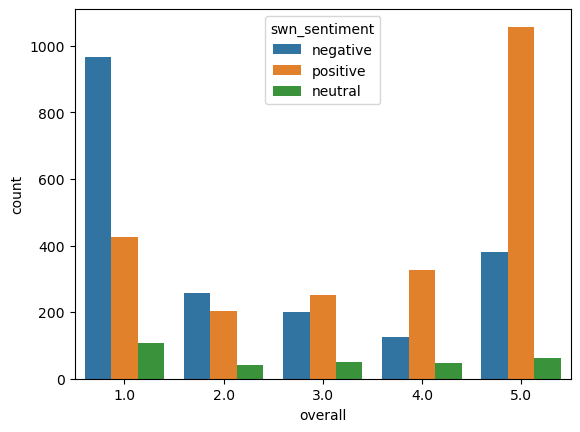

In [20]:
sns.countplot(x ="overall",hue ="swn_sentiment" , data = data)

In [21]:
data['true_sentiment'] = data['overall'].apply(lambda x:"positive" if x>=4 else "negative" if x<3 else "neutral")

In [22]:
data[["reviewText","swn_score","swn_sentiment","true_sentiment"]].head(10)

,reviewText,swn_score,swn_sentiment,true_sentiment
0,Terrible game!! The guns sound ridiculous and ...,-13.446970,negative,negative
1,fun?! ZERO is what I should be allowed to give...,5.917283,positive,negative
2,If you like standard controls you will hate th...,-2.083333,negative,negative
3,it didn't work when I got it.,1.785714,positive,negative
4,I found it hard to get the controls to do what...,-1.314484,negative,negative
5,no clear mission,16.666667,positive,negative
6,"Sega used to be a good company, but this is li...",-3.425802,negative,negative
7,This game is not worth the time it takes you t...,-2.380952,negative,negative
8,it came in a sandwich bag dude and i think who...,0.581395,neutral,negative
9,Its a shame to much opposite to the regular MO...,1.470588,positive,negative


In [23]:
predSentiment = data['swn_sentiment'].tolist()
trueSentiment = data['true_sentiment'].tolist()

In [24]:
metrics.confusion_matrix(predSentiment,trueSentiment)

array([[1221,  199,  507],
       [ 149,   51,  108],
       [ 630,  250, 1384]], dtype=int64)

In [25]:
metrics.accuracy_score(predSentiment,trueSentiment)

0.5903534118693043

In [26]:
conf = metrics.ConfusionMatrixDisplay((metrics.confusion_matrix(predSentiment,trueSentiment)))

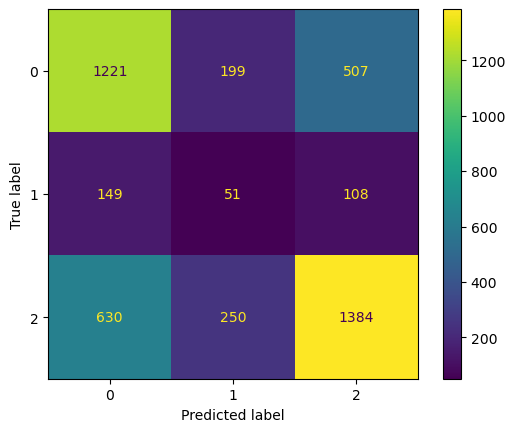

In [27]:
conf.plot()

In [28]:
print(metrics.classification_report(predSentiment,trueSentiment))

              precision    recall  f1-score   support

    negative       0.61      0.63      0.62      1927
     neutral       0.10      0.17      0.13       308
    positive       0.69      0.61      0.65      2264

    accuracy                           0.59      4499
   macro avg       0.47      0.47      0.47      4499
weighted avg       0.62      0.59      0.60      4499

